In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
from scipy.stats import linregress, t, gaussian_kde, mannwhitneyu, hmean, combine_pvalues, fisher_exact, ttest_1samp
from pybedtools import BedTool, helpers
import statsmodels.api as sm
from tqdm import tqdm
import multiprocessing as mp
# helpers.set_tempdir(
#         '/home/jupyter/workspaces/neanderthalintrogressionlandscapeinafricanamericans/introgression_african_americans')

In [2]:
def read_ibdmix_results(filename):
    ibdmix = pd.read_csv(filename, sep='\t', names=['chrom', 'start', 'end', "LOD", "IID", 
                                                    "pop", "super_pop"])
    ibdmix['length'] = (ibdmix.end - ibdmix.start)
    return ibdmix

def load_npz(fn):
    arr = np.load(fn, allow_pickle=True)
    arr = arr['arr_0']
    return arr

def sort_individuals(df, K):
    """
    Sort individuals by modal ancestry components and it's intensity
    :param df: pd.DataFrame, data frame containing ancestry porportions
    :param K: int, K used to run admixture
    :return: pd.DataFrame, sorted df
    """
    # get mean ancestry per component for each population
    mean_ancestry_pops = df.groupby('population').mean()
    # identify modal component for each population, i.e., the component with the highest ancestry proportion
    modal_clusters_pops = mean_ancestry_pops.idxmax(axis=1).sort_values()
    individual_orders = []
    # iterate over all k
    for i in df.columns[:-1]:
        # get all populations for which the current component is model
        pops = modal_clusters_pops[modal_clusters_pops == i].index.values.tolist()
        # sort the population by they mean ancestry proportions of the modal component
        pops_sorted = mean_ancestry_pops.loc[pops, i].sort_values(ascending=False).index.values
        inds = []
        # sort the individuals within a population by ancestry proportion
        for pop in pops_sorted:
            inds.extend(df.loc[df.population == pop, i].sort_values(ascending=False).index.values.tolist())
        individual_orders.extend(inds)

    df = df.loc[individual_orders, :]
    return df


def plot_admixture_proportions(df, K):
    """
    Create horizontal bar plot of ADMIXTURE results
    :param df: pd.DataFrame, sorted DataFrame with ancestry proportions
    :param K: int, K used for admixture run
    """
    colors = ["red", "green", "blue", 'orange']
    # pad colors
    while K > len(colors):
        colors.append((np.random.random(), np.random.random(), np.random.random()))
    fig, ax = plt.subplots(figsize=(2, 8))
    populations = df.population.values
    y_coords = [0]
    y_ticks = []
    y_labels = []
    prev_pop = populations[0]
    pop_coord_start = 0
    cumulative_padding = 0
    padding = 2
    for i, pop in enumerate(populations[1:], 1):
        if prev_pop != pop:
            # get ytick positions and labels
            y_ticks.append((pop_coord_start + i + cumulative_padding - 1) / 2)
            if prev_pop == 'AA':
                y_labels.append('Admixed')
            else:
                y_labels.append(prev_pop)
            prev_pop = pop
            # add white space between populations
            cumulative_padding += padding
            pop_coord_start = i + cumulative_padding
        # determine y coords --> add white space between populations
        y_coords.append(i + cumulative_padding)
    y_ticks.append((pop_coord_start + i + cumulative_padding) / 2)
    if prev_pop == 'AA':
        y_labels.append('Admixed')
    else:
        y_labels.append(prev_pop)
    prev_k = []
    # do plotting
    for i, anc in enumerate(df.columns[:-1]):
        if i > 0:
            ax.barh(y_coords, df.loc[:, anc], left=df.loc[:, prev_k].sum(axis=1), height=1, color=colors[i])
        else:
            ax.barh(y_coords, df.loc[:, anc], height=1, color=colors[i])
        prev_k.append(anc)
    # formatting
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=10)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.invert_yaxis()
    ax.set_xlabel(f"K={K}", fontsize=12)
    ax.set_ylim([len(populations) + cumulative_padding - 0.5, -0.5])
    ax.set_xlim([0, 1])
    return fig, ax

def read_flare(fname_pattern):
    dfs = []
    for chrom in range(1, 23):
        phase_0 = pd.read_csv(fname_pattern.format(chrom=chrom, phase=0),
                             header=0, sep='\t')
        phase_0['phase'] = 0
        phase_1 = pd.read_csv(fname_pattern.format(chrom=chrom, phase=1),
                             header=0, sep='\t')
        phase_1['phase'] = 1
        dfs.append(phase_0)
        dfs.append(phase_1)
    df = pd.concat(dfs)
    df['length'] = df.end - df.start
    return df


def linear_regression(x, y, full_range=False):
    reg = linregress(x, y)
    if not full_range:
        x2 = np.linspace(x.min(), x.max(), 100)
    else:
        x2 = np.linspace(min([x.min(), y.min()]), 
                         max([x.max(), y.max()]), 100)
    y2 = x2 * reg.slope + reg.intercept
#     https://github.com/BMClab/BMC/blob/0c338ecf74798379d724a0f27f399c96b7aecbe3//notebooks/CurveFitting.ipynb
    # Confidence interval for the linear fit:
    zscore = t.ppf(0.975, x.shape[0] - 2)
    s_err = s_err = np.sqrt(np.sum((y - (x * reg.slope + reg.intercept))**2)/(x.shape[0] - 2))
    ci = zscore * s_err * np.sqrt(1 / x.shape[0] + (x2 - np.mean(x))**2/np.sum((x2 - np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = zscore * s_err * np.sqrt(1 + 1 / x.shape[0] + (x2 - np.mean(x))**2 / np.sum((x2 - np.mean(x))**2))
    print(f'Slope: {reg.slope} 95% CI: {reg.slope - reg.stderr * 1.96} - {reg.slope + reg.stderr * 1.96}')
    print(f'Intercept: {reg.intercept} 95% CI: {reg.intercept - reg.intercept_stderr * 1.96} - {reg.intercept + reg.intercept_stderr * 1.96}')
    
    return reg.slope, reg.intercept, reg.rvalue, reg.pvalue, x2, y2, ci, pi
    

def make_violinplot(amounts, position, ax, color, width=0.5, alpha=1):
    parts = ax.violinplot(amounts, showmedians=True, positions=[position], widths=width)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.1)
        pc.set_alpha(alpha)
    parts['cmedians'].set_color('black')
    parts['cmins'].set_color('black')
    parts['cmaxes'].set_color('black')
    parts['cbars'].set_color('black')
    return ax

def compare_amounts_predicted_introgressed_sequence_by_populations(df, neanderthal, ax=None, fig=None):
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    amounts = df.groupby(['super_pop', 'pop', 'IID']).sum().loc[:, 'length'] / 1e6
    super_pops = amounts.index.get_level_values(0).unique()
    n = 0
    xlabels = []
    for super_pop, color in zip(['EAS', 'EUR', 'AFR', 'AMR'], 
                                ['Greens_r', 'Blues_r', 'Reds_r', 'purple']):
        if super_pop in super_pops:
            c_amounts = amounts.loc[(super_pop, slice(None), slice(None))]
        else:
            continue
        populations = c_amounts.index.get_level_values(0).unique()
        if len(populations) > 1:
            cmap = plt.colormaps[color]
        else:
            cmap = color
        for i, pop in enumerate(populations, 1):
            try:
                ax = make_violinplot(c_amounts.loc[pop, :], n, ax, cmap(i * 30))
            except TypeError:
                ax = make_violinplot(c_amounts.loc[pop, :], n, ax, cmap)
            n += 1
            if pop == 'AA':
                xlabels.append('Admixed')
            else:
                xlabels.append(pop)
    ax.set_xticks(np.arange(0, len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=0)
    ax.set_ylabel(f'{neanderthal} introgressed per individual (Mb)')
    return fig, ax


def plot_haplotype_frequencies(df, column, chrom, ax, alpha, color):
    c_starts = df.loc[df.chrom == chrom, 'start'].values / 1e6
    c_freqs = df.loc[df.chrom == chrom, column].values
    c_ends = df.loc[df.chrom == chrom, 'end'].values / 1e6
    ax.bar(c_starts, c_freqs, c_ends - c_starts, align='edge', color=color, alpha=alpha)
    return ax



In [3]:
K = 3
admixture_proportions = pd.read_csv(f'data/merged_datasets/test_ancestry_proportions-20.9.Q', sep='\t', 
                                    header=0, index_col=0)
# retain only admixed individuals
aa_individuals = pd.read_csv('data/AA_sample_ids.txt', names=['sample'])
admixture_proportions = admixture_proportions[np.isin(admixture_proportions.index.values, 
                                                      aa_individuals['sample'].values)]
# add population for downstream compatibility
admixture_proportions['population'] = 'AA'
admixture_proportions.rename(columns={'WestAfrican': 'AFR', 'NorthernEuropean': 'EUR', 'EastAsian': 'EAS'}, inplace=True)
# aggregate Asian ancestries to EAS
admixture_proportions.EAS += admixture_proportions.Mayan
admixture_proportions.EAS += admixture_proportions.Pima
admixture_proportions.AFR += admixture_proportions.EastAfrican
admixture_proportions.EUR += admixture_proportions.WesternEuropean
admixture_proportions.EUR += admixture_proportions.SouthernEuropean
admixture_proportions.EUR += admixture_proportions.Iberian


# drop aggregated ancestries
admixture_proportions.drop(['Mayan', 'Pima', 'EastAfrican', 'WesternEuropean', 'Iberian', 'SouthernEuropean'],
                           axis=1, inplace=True)
# sort
admixture_proportions.sort_values(['AFR', 'EUR', 'EAS'], inplace=True)
admixture_proportions.index = admixture_proportions.index.values.astype(str)
# plot
# fig, ax = plot_admixture_proportions(admixture_proportions, K)
# fig.savefig('visualizations/admixture.pdf', bbox_inches='tight', dpi=600)

In [4]:
ibdmix_vindija = read_ibdmix_results('results50kb_all_test/ibdmix_Vindija33.19/ibdmix_results_masked_denisovan_combined_50kb_4.0LOD.bed')
ibdmix_altai = read_ibdmix_results('results50kb_all_test/ibdmix_Altai/ibdmix_results_masked_denisovan_combined_50kb_4.0LOD.bed')
ibdmix_chagyrskaya = read_ibdmix_results('results50kb_all_test/ibdmix_Chagyrskaya/ibdmix_results_masked_denisovan_combined_50kb_4.0LOD.bed')

ibdmix_vindija_masked = read_ibdmix_results('results50kb_all_test/ibdmix_Vindija33.19/ibdmix_results_masked_denisovan_combined_50kb_4.0LOD_afr_masked.bed')
ibdmix_altai_masked = read_ibdmix_results('results50kb_all_test/ibdmix_Altai/ibdmix_results_masked_denisovan_combined_50kb_4.0LOD_afr_masked.bed')
ibdmix_chagyrskaya_masked = read_ibdmix_results('results50kb_all_test/ibdmix_Chagyrskaya/ibdmix_results_masked_denisovan_combined_50kb_4.0LOD_afr_masked.bed')


# fig, ax = compare_amounts_predicted_introgressed_sequence_by_populations(ibdmix_vindija, 'Vindija33.19')
# fig, ax = compare_amounts_predicted_introgressed_sequence_by_populations(ibdmix_vindija_masked, 'Vindija33.19')

# fig, ax = compare_amounts_predicted_introgressed_sequence_by_populations(ibdmix_altai, 'Altai')
# fig, ax = compare_amounts_predicted_introgressed_sequence_by_populations(ibdmix_chagyrskaya, 'Chagyrskaya')

In [24]:
def calculate_expected_introgression(admixture_proportions, ibdmix):
    # calculate introgressed amount per individual
    amounts = ibdmix.groupby('IID').sum().loc[:, ['length']] / 1e6
    # join with admixture proportions
    amounts = amounts.join(admixture_proportions)
    # select admixed individuals only
    amounts = amounts[amounts.population == 'AA']
    super_pop_indv_mapping = ibdmix.drop_duplicates("IID").loc[:, ["IID", 'super_pop']].set_index('IID')
    # groupby individual
    amount_introgression_per_indv = ibdmix.loc[:, ['IID', 'length']].groupby('IID').sum() / 1e6
    # calculate mean per continental population
    amount_introgression_superpop_per_indv = super_pop_indv_mapping.join(amount_introgression_per_indv)
    mean_introgression_per_superpop = amount_introgression_superpop_per_indv.groupby('super_pop').mean()
    if not 'AFR' in mean_introgression_per_superpop.index:
        mean_introgression_per_superpop.loc['AFR', 'length'] = 0.0
    if not 'EUR' in mean_introgression_per_superpop.index:
        mean_introgression_per_superpop.loc['EUR', 'length'] = 0.0
    if not 'EAS' in mean_introgression_per_superpop.index:
        mean_introgression_per_superpop.loc['EAS', 'length'] = 0.0
    amounts['expected_introgression'] = (amounts.AFR * 
                                         mean_introgression_per_superpop.loc['AFR', 'length'] + 
                                         amounts.EUR * 
                                         mean_introgression_per_superpop.loc['EUR', 'length'] +
                                         amounts.EAS * 
                                         mean_introgression_per_superpop.loc['EAS', 'length'])
        
    return amounts

def plot_observed_vs_expected_amounts(amounts, color_scatter='lightblue', color_reg='blue', ax=None):
    # do regression
    (slope, intercept, rval, pval, x_model, y_model, 
     ci, pi) = linear_regression(amounts.expected_introgression, amounts['length'], full_range=True)
    if ax is None:
        fig, ax = plt.subplots()
    amounts =  amounts.copy()
    amounts.reset_index(inplace=True)
    xy = np.vstack([amounts.expected_introgression, amounts['length']])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = amounts.loc[idx, 'expected_introgression'], amounts.loc[idx, 'length'], z[idx]
#     cax = ax.scatter(x, y, s=2, cmap=color_scatter, 
#                      norm=LogNorm(vmin=z.min(), vmax=z.max()))
    ax.scatter(amounts.expected_introgression.values, amounts['length'].values, c=color_scatter, s=2)
    ax.plot(x_model, y_model, ls='--', color=color_reg,
            label=f'a={np.round(slope, 2)}; c={np.round(intercept, 2)}')
#     ax.fill_between(x_model, y_model + ci, y_model - ci, color=color_reg, alpha=0.4)
    if pval <= 1e-6:
        ax.annotate(r'$p\leq10^{-6}$; ' + r'$r$' + 
                    '={:.2f}'.format(rval), (1, 1), (0.05, 0.93), 
                   xycoords='axes fraction', fontsize=7)
    else:
        ax.annotate('p={:.2e}; '.format(pval) + r'$r$' + 
                    '={:.2f}'.format(rval), (1, 1), (0.05, 0.93), 
                       xycoords='axes fraction', fontsize=7)
    ax.plot(x_model, x_model, ls='--', c='black', label='a=1, c=0')
    ax.legend(bbox_to_anchor=(0.5, -.34), loc='center', ncol=2, fontsize=7, labelspacing=0.01,
              handlelength=1.4, columnspacing=0.5, handletextpad=0.4)
    # ax.plot(x_model, y_model + pi, ls=':', color='blue')
    # ax.plot(x_model, y_model - pi, ls=':', color='blue')
#     ax.set_xlabel('Exp. introgression (Mb)', fontsize=8)
#     ax.set_ylabel('Obs. introgression per individual (Mb)', fontsize=10)
    min_lim = max([min([amounts.expected_introgression.min(), amounts['length'].min()]) - 1, 0])
    max_lim = max([amounts.expected_introgression.max(), amounts['length'].max()]) + 1
    ax.set_xlim([min_lim, max_lim])
    ax.set_ylim([min_lim, max_lim])
    ax.set_aspect('equal')
    
    return ax, cax

def plot_hist_of_ratios_of_obs_vs_exp_amounts(df, color, simulation_ratios, ax=None,
                                              bins=np.linspace(-.2, .5, 200), 
                                              color_sim='gray'):
    if ax is None:
        fig, ax = plt.subplots()
    
    for i in range(simulation_ratios.shape[0]):
        if simulation_ratios[i].shape[0] < 900:
#             print(i)
            continue
        ax.hist(np.log10(simulation_ratios[i].astype(float)), bins=bins, histtype='step', color=color_sim,
                weights=np.repeat(1 / simulation_ratios[i].shape[0], simulation_ratios[i].shape[0]), 
                alpha=0.1)
    ax.hist(np.log10(df['length'] / df['expected_introgression']), bins=bins, histtype='step', color=color,
            weights=np.repeat(1 / df.shape[0], df.shape[0]), alpha=1)
    ax.axvline(0, ls='--', color='black')
#     test = ttest_1samp(np.log(df['length'] / df['expected_introgression']), 0)
#     if test.pvalue <= 1e-6:
#         ax.annotate('P' r'$\leq$' + '{:.0e}'.format(1e-6), (1, 1), (0.8, 0.95), 
#                     xycoords='axes fraction')
#     else:
#         ax.annotate('P={:.3e}'.format(test.pvalue), (1, 1), (0.8, 0.95), 
#                    xycoords='axes fraction')
    ax.axvline(0, ls='--', color='black')
    ax.set_xlabel(r'$log10(\frac{Observed\ introgression\ in\ Mb}{Expected\ introgression\ in\ Mb})$')
    return ax

def plot_hist_of_diff_of_obs_vs_exp_amounts(df, color, simulation_diffs, ax=None,
                                            bins=np.linspace(-.2, .5, 200), 
                                            color_sim='gray', data='unfiltered'):
    if ax is None:
        fig, ax = plt.subplots()
    
    for i in range(simulation_diffs.shape[0]):
        # divide diff by simulated genome size
        ax.hist(simulation_diffs[i] / (903043000 / 1e6) * 100, bins=bins, histtype='step', color=color_sim,
                weights=np.repeat(1 / simulation_diffs[i].shape[0], simulation_diffs[i].shape[0]), 
                alpha=0.4)
    # divide diff by autosomal genome size
    ax.hist((df['length'] - df['expected_introgression']) / (2875001522 / 1e6) * 100, bins=bins, 
            histtype='step', color=color,
            weights=np.repeat(1 / df.shape[0], df.shape[0]), alpha=1)
    ax.axvline(0, ls='--', color='black')
    if data == 'unfiltered':
        ax.set_xlabel('Unfiltered obs. - exp.\nNeanderthal admixture fraction (%)', fontsize=7)
    elif data == 'afr':
        ax.set_xlabel('African masked obs. - exp.\nNeanderthal admixture fraction (%)', fontsize=7)
#     test = ttest_1samp(np.log(df['length'] / df['expected_introgression']), 0)
#     if test.pvalue <= 1e-6:
#         ax.annotate('P' r'$\leq$' + '{:.0e}'.format(1e-6), (1, 1), (0.8, 0.95), 
#                     xycoords='axes fraction')
#     else:
#         ax.annotate('P={:.3e}'.format(test.pvalue), (1, 1), (0.8, 0.95), 
#                    xycoords='axes fraction')
    ax.axvline(0, ls='--', color='black')
    return ax

def load_simulations(prefix):
    ratios = load_npz(f'{prefix}_ratios.npz')
    ratios_short = load_npz(f'{prefix}_ratios_short_segments.npz')
    ratios_medium = load_npz(f'{prefix}_ratios_medium_segments.npz')
    ratios_long = load_npz(f'{prefix}_ratios_long_segments.npz')

    differences = load_npz(f'{prefix}_differences.npz')
    differences_short = load_npz(f'{prefix}_differences_short_segments.npz')
    differences_medium = load_npz(f'{prefix}_differences_medium_segments.npz')
    differences_long = load_npz(f'{prefix}_differences_long_segments.npz')

    slopes = load_npz(f'{prefix}_slopes.npz')
    intercepts = load_npz(f'{prefix}_intercepts.npz')
    try:
        lengths = load_npz(f'{prefix}_segment_lengths.npz')
        lengths = np.concatenate(lengths) / 1000
    except:
        print(f"couldn't load {prefix}_segment_lengths.npz")
        lengths = []
    try:
        lods = load_npz(f'{prefix}_segment_lods.npz')
        lods = np.concatenate(lods)
    except:
        print(f"couldn't load {prefix}_segment_lods.npz")
        lods = []
    return (ratios, ratios_short, ratios_medium, ratios_long, differences, differences_short, 
            differences_medium, differences_long, slopes, intercepts, lengths, lods) 

# def plot_scatter_and_simulated_hist(amounts, simulations_simple, simulations_full,
def plot_scatter_and_simulated_hist(amounts, simulations,
                                    histrange=(-.5, .5), color_scatter='royalblue', color_reg='blue',
                                    color_sim='blue', plot_difference=False):
    fig = plt.figure(figsize=(10, 6))
    gs_outer = fig.add_gridspec(1, 2, width_ratios=[5, 6], wspace=0.25)
    gs2 = gridspec.GridSpecFromSubplotSpec(44, 20, subplot_spec = gs_outer[1], wspace=0.15)

    ax = fig.add_subplot(gs_outer[0])
    
    ax1 = fig.add_subplot(gs2[8:36, 3:])
#     ax2 = fig.add_subplot(gs2[4:21, 1], sharey=ax1)
#     plt.subplots_adjust(wspace=1.5)
    bins = np.linspace(histrange[0], histrange[1], 200)
    ax, cax = plot_observed_vs_expected_amounts(amounts, ax=ax, color_scatter=color_scatter, 
                                           color_reg=color_reg)
    divider = make_axes_locatable(ax)
    c_ax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(cax, cax=c_ax, ax=ax)
    cbar.set_label('Density')
    if plot_difference:
        ax1 = plot_hist_of_diff_of_obs_vs_exp_amounts(amounts, color_sim, simulations,
                                                        ax=ax1, bins=bins)
#         ax2 = plot_hist_of_diff_of_obs_vs_exp_amounts(amounts, color_sim, simulations_full,
#                                                         ax=ax2, bins=bins)
    else:
        ax1 = plot_hist_of_ratios_of_obs_vs_exp_amounts(amounts, color_sim, simulations,
                                                        ax=ax1, bins=bins)
#         ax2 = plot_hist_of_ratios_of_obs_vs_exp_amounts(amounts, color_sim, simulations_full,
#                                                         ax=ax2, bins=bins)
#     plt.setp(ax2.get_yticklabels(), visible=False)
    # ax[2].set_xticks([])

    handles = [Line2D([0], [0], ls='-', color='gray', label='Simulations'),
               Line2D([0], [0], ls='-', color=color_sim, label='Admixed individuals')]
    ax1.legend(handles=handles, bbox_to_anchor=(0.5, -.2), ncol=2, loc='upper center')
    ax1.set_ylabel('Density')



#     ax1.set_title("Model I", fontsize=10)
#     ax2.set_title("Model II", fontsize=10)

    ax.annotate("A", (1, 1), (-.25, 0.95), xycoords='axes fraction', fontsize=14, fontweight='bold')
    ax1.annotate("B", (1, 1), (-.2, 0.95), xycoords='axes fraction', fontsize=14, fontweight='bold')
    return fig, ax, ax1


# amounts_vindija = calculate_expected_introgression(admixture_proportions, ibdmix_vindija)
# amounts_altai = calculate_expected_introgression(admixture_proportions, ibdmix_altai)
# amounts_chagyrskaya = calculate_expected_introgression(admixture_proportions, ibdmix_chagyrskaya)

# (simulations_ratios, simulations_ratios_short, 
#  simulations_ratios_medium, simulations_ratios_long, 
#  simulations_differences, simulations_differences_short, 
#  simulations_differences_medium, 
#  simulations_differences_long, simulations_slopes, 
#  simulations_intercepts, simulations_lengths, 
#  simulations_lods) = load_simulations('simulations')

In [6]:
amounts_vindija_masked = calculate_expected_introgression(admixture_proportions, ibdmix_vindija_masked)
amounts_altai_masked = calculate_expected_introgression(admixture_proportions, ibdmix_altai_masked)

amounts_chagyrskaya_masked = calculate_expected_introgression(admixture_proportions, ibdmix_chagyrskaya_masked)


(simulations_afr_masked_ratios, simulations_afr_masked_ratios_short, 
 simulations_afr_masked_ratios_medium, simulations_afr_masked_ratios_long, 
 simulations_afr_masked_differences, simulations_afr_masked_differences_short, 
 simulations_afr_masked_differences_medium, 
 simulations_afr_masked_differences_long, simulations_afr_masked_slopes, 
 simulations_afr_masked_intercepts, simulations_afr_masked_lengths, 
 simulations_afr_masked_lods) = load_simulations('simulations_afr_masked')

Slope: 1.2178844600248224 95% CI: 1.0834277681467288 - 1.352341151902916
Intercept: -4.088669623430594 95% CI: -6.848989166115025 - -1.3283500807461617
Slope: 1.0985016907539031 95% CI: 0.967833841499297 - 1.2291695400085094
Intercept: -0.7639722259838364 95% CI: -1.3351648196090928 - -0.19277963235857998
Slope: 1.2636391378851162 95% CI: 1.092209538741176 - 1.4350687370290562
Intercept: -5.183068422052859 95% CI: -9.389110005501422 - -0.9770268386042966
Slope: 1.1631260035706013 95% CI: 1.0285954561069799 - 1.2976565510342226
Intercept: -0.8058268826801163 95% CI: -1.3089086471839058 - -0.30274511817632677
Slope: 1.242606373545491 95% CI: 1.1166769072210505 - 1.3685358398699317
Intercept: -4.20433651566265 95% CI: -6.608426812537571 - -1.8002462187877288
Slope: 1.0892312592158075 95% CI: 0.9557928615379996 - 1.2226696568936155
Intercept: -0.6455702821046732 95% CI: -1.2012591244587307 - -0.08988143975061569


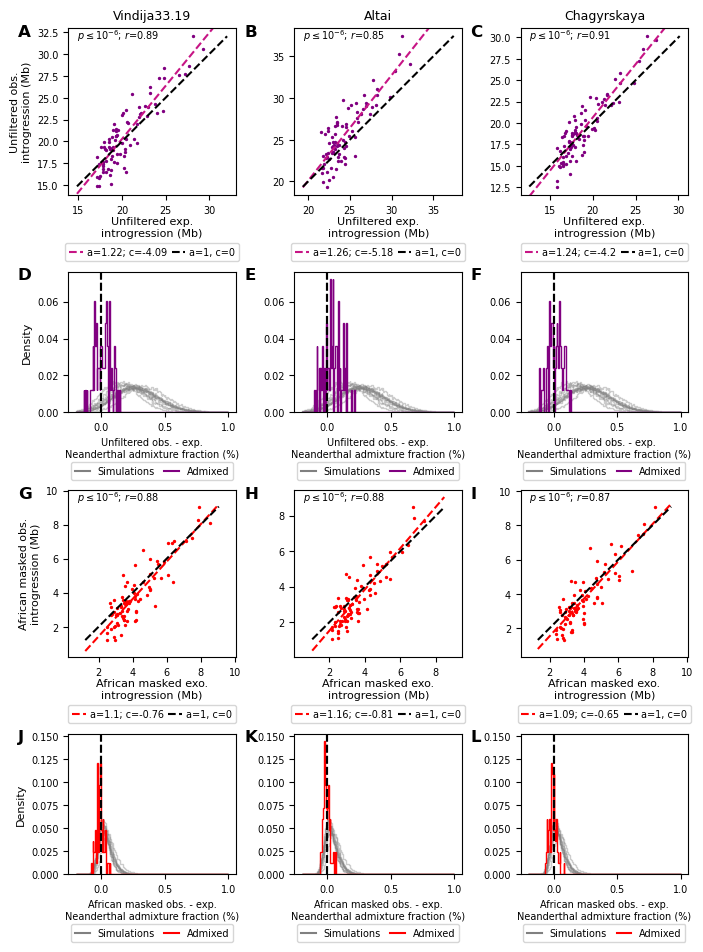

In [27]:
def plot_colorbar(ax, cax, fig):
    divider = make_axes_locatable(ax)
    c_ax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(cax, cax=c_ax, ax=ax)
    cbar.set_label('Density')

fig= plt.figure(figsize=(8, 11))

gs_outer = fig.add_gridspec(4, 1, hspace=0.5, height_ratios=[6, 5, 6, 5])
gs0 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = gs_outer[0], 
                                       wspace=0.35)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = gs_outer[1], 
                                       wspace=0.35)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = gs_outer[2], 
                                       wspace=0.35)
gs3 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = gs_outer[3], 
                                       wspace=0.35)

ax0 = fig.add_subplot(gs0[0])
ax1 = fig.add_subplot(gs0[1])
ax2 = fig.add_subplot(gs0[2])
ax3 = fig.add_subplot(gs1[0])
ax4 = fig.add_subplot(gs1[1], sharey=ax3)
ax5 = fig.add_subplot(gs1[2], sharey=ax3)

ax6 = fig.add_subplot(gs2[0])
ax7 = fig.add_subplot(gs2[1])
ax8 = fig.add_subplot(gs2[2])
ax9 = fig.add_subplot(gs3[0])
ax10 = fig.add_subplot(gs3[1], sharey=ax9)
ax11 = fig.add_subplot(gs3[2], sharey=ax9)
# ax12 = fig.add_subplot(gs0[3])
# ax13 = fig.add_subplot(gs2[3])


handles_full = [Line2D([0], [0], ls='-', color='gray', label='Simulations'),
                Line2D([0], [0], ls='-', color='purple', label='Admixed')]
handles_masked = [Line2D([0], [0], ls='-', color='gray', label='Simulations'),
                Line2D([0], [0], ls='-', color='red', label='Admixed')]

ax0, cax = plot_observed_vs_expected_amounts(amounts_vindija, ax=ax0, color_scatter='purple', 
                                            color_reg='mediumvioletred')
ax0.set_ylabel('Unfiltered obs.\nintrogression (Mb)', fontsize=8)
ax0.set_xlabel('Unfiltered exp.\nintrogression (Mb)', fontsize=8, labelpad=1)

ax0.set_title('Vindija33.19', fontsize=9)
ax6, cax3 = plot_observed_vs_expected_amounts(amounts_vindija_masked, ax=ax6, color_scatter='red', 
                                            color_reg='red')
ax6.set_ylabel('African masked obs.\nintrogression (Mb)', fontsize=8)
ax6.set_xlabel('African masked exo.\nintrogression (Mb)', fontsize=8, labelpad=1)

ax1, cax1 = plot_observed_vs_expected_amounts(amounts_altai, ax=ax1, color_scatter='purple', 
                                            color_reg='mediumvioletred')
ax1.set_title('Altai', fontsize=9)
ax1.set_xlabel('Unfiltered exp.\nintrogression (Mb)', fontsize=8, labelpad=1)

ax7, cax4 = plot_observed_vs_expected_amounts(amounts_altai_masked, ax=ax7, color_scatter='red', 
                                            color_reg='red')
ax7.set_xlabel('African masked exo.\nintrogression (Mb)', fontsize=8, labelpad=1)

ax2, cax2 = plot_observed_vs_expected_amounts(amounts_chagyrskaya, ax=ax2, color_scatter='purple', 
                                            color_reg='mediumvioletred')
ax2.set_title('Chagyrskaya', fontsize=9)
ax2.set_xlabel('Unfiltered exp.\nintrogression (Mb)', fontsize=8, labelpad=1)

ax8, cax5 = plot_observed_vs_expected_amounts(amounts_chagyrskaya_masked, ax=ax8, color_scatter='red', 
                                            color_reg='red')
ax8.set_xlabel('African masked exo.\nintrogression (Mb)', fontsize=8, labelpad=1)

# plot_colorbar(ax0, cax, fig)
# plot_colorbar(ax1, cax1, fig)
# plot_colorbar(ax12, cax2, fig)
# plot_colorbar(ax6, cax3, fig)
# plot_colorbar(ax7, cax4, fig)
# plot_colorbar(ax13, cax5, fig)


bins = np.linspace(-.2, 1, 200)

ax3 = plot_hist_of_diff_of_obs_vs_exp_amounts(amounts_vindija, 'purple', simulations_differences,
                                              ax=ax3, bins=bins)
ax3.set_ylabel('Density', fontsize=8)

ax3.legend(handles=handles_full, bbox_to_anchor=(0.5, -.42), loc='center', ncol=2, fontsize=7, 
           labelspacing=0.2, handlelength=1.5, columnspacing=1)
ax3.tick_params(axis='x', labelsize=6)
ax3.tick_params(axis='y', labelsize=6)

ax9 = plot_hist_of_diff_of_obs_vs_exp_amounts(amounts_vindija_masked, 'red', 
                                              simulations_afr_masked_differences,
                                              ax=ax9, bins=bins, data='afr')
ax9.legend(handles=handles_masked, bbox_to_anchor=(0.5, -.42), loc='center', ncol=2, fontsize=7, 
           labelspacing=0.2, handlelength=1.5, columnspacing=1)
ax9.set_ylabel('Density', fontsize=8)

ax4 = plot_hist_of_diff_of_obs_vs_exp_amounts(amounts_altai, 'purple', simulations_differences,
                                              ax=ax4, bins=bins)
ax4.legend(handles=handles_full, bbox_to_anchor=(0.5, -.42), loc='center', ncol=2, fontsize=7, 
           labelspacing=0.2, handlelength=1.5, columnspacing=1)
# ax4.set_yticklabels([])
ax10 = plot_hist_of_diff_of_obs_vs_exp_amounts(amounts_altai_masked, 'red', 
                                               simulations_afr_masked_differences,
                                              ax=ax10, bins=bins, data='afr')
ax10.legend(handles=handles_masked, bbox_to_anchor=(0.5, -.42), loc='center', ncol=2, fontsize=7, 
           labelspacing=0.2, handlelength=1.5, columnspacing=1)
# ax10.set_yticklabels([])

ax5 = plot_hist_of_diff_of_obs_vs_exp_amounts(amounts_chagyrskaya, 'purple', simulations_differences,
                                              ax=ax5, bins=bins)
ax5.legend(handles=handles_full, bbox_to_anchor=(0.5, -.42), loc='center', ncol=2, fontsize=7, 
           labelspacing=0.2, handlelength=1.5, columnspacing=1)
# ax5.set_yticklabels([])

ax11 = plot_hist_of_diff_of_obs_vs_exp_amounts(amounts_chagyrskaya_masked, 'red', 
                                               simulations_afr_masked_differences,
                                              ax=ax11, bins=bins, data='afr')
ax11.legend(handles=handles_masked, bbox_to_anchor=(0.5, -.42), loc='center', ncol=2, fontsize=7, 
           labelspacing=0.2, handlelength=1.5, columnspacing=1)
# ax11.set_yticklabels([])
ax0.tick_params(axis='x', labelsize=7)
ax0.tick_params(axis='y', labelsize=7)
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
ax2.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='y', labelsize=7)
ax3.tick_params(axis='x', labelsize=7)
ax3.tick_params(axis='y', labelsize=7)
ax4.tick_params(axis='x', labelsize=7)
ax4.tick_params(axis='y', labelsize=7)
ax5.tick_params(axis='x', labelsize=7)
ax5.tick_params(axis='y', labelsize=7)
ax6.tick_params(axis='x', labelsize=7)
ax6.tick_params(axis='y', labelsize=7)
ax7.tick_params(axis='x', labelsize=7)
ax7.tick_params(axis='y', labelsize=7)
ax8.tick_params(axis='x', labelsize=7)
ax8.tick_params(axis='y', labelsize=7)
ax9.tick_params(axis='x', labelsize=7)
ax9.tick_params(axis='y', labelsize=7)
ax10.tick_params(axis='x', labelsize=7)
ax10.tick_params(axis='y', labelsize=7)
ax11.tick_params(axis='x', labelsize=7)
ax11.tick_params(axis='y', labelsize=7)
ax0.annotate("A", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax1.annotate("B", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax2.annotate("C", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax3.annotate("D", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax4.annotate("E", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax5.annotate("F", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax6.annotate("G", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax7.annotate("H", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax8.annotate("I", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax9.annotate("J", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax10.annotate("K", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax11.annotate("L", (1, 1), (-.3, 0.95), xycoords='axes fraction', fontsize=12, fontweight='bold')

fig.savefig('visualizations/comp_nea.png', bbox_inches='tight', dpi=600)
fig.savefig('visualizations/comp_nea.pdf', bbox_inches='tight', dpi=600)